<a href="https://colab.research.google.com/github/jaanvi-prabhakar/SP-BTT-Patent-Classification/blob/fixes/code_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the public patents dataset
- The dataset is comprised of 9 small datasets:  
  https://huggingface.co/datasets/NortheasternUniversity/big_patent  
- Each of the 9 dataset contains patents from a particular category:  
```
	                train	  validation	test
all categories	1207222    67068 	    67072
a	              174134 	9674	      9675
b	              161520 	8973	      8974
c	              101042 	5613	      5614
d	               10164	  565	       565
e	               34443	 1914      	1914
f	               85568	 4754	      4754
g	              258935	14385	     14386
h	              257019	14279     	14279
y	              124397	 6911	      6911  
,
a: Human Necessities
b: Performing Operations; Transporting
c: Chemistry; Metallurgy
d: Textiles; Paper
e: Fixed Constructions
f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
g: Physics
h: Electricity
y: General tagging of new or cross-sectional technology
```  

- Memory issues in Colab:  
 It isn't possible to hold all the "training" sets in Colab's ~13GB RAM, moreover, holding the "training" set for category g alone isn't possible.  
 So, to make this data collection possible in Colab, we are taking only the "validation" set.  

Install Hugging Face's `datasets`:  
and Google's `generativeai`

In [1]:
!pip install datasets -q
!pip install -q -U google-generativeai

Imports:

In [2]:
# This code is assumed to be run in Google Colab
from google.colab import files
from datasets import load_dataset
import pandas as pd
import pickle
import psutil
import gc
import numpy as np
import re
import matplotlib.pyplot as plt
import json
import time
import google.generativeai as genai
from google.colab import userdata
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'google.colab'

Setting and variables:

In [ ]:
# Set printout:
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.max_rows', None)

# Decide whether to import the dataset from online (to do only once), or to load from memory after having importing from online:
import_dataset = False

LABELS = {
    "a":"Human Necessities",
    "b": "Performing Operations; Transporting",
    "c": "Chemistry; Metallurgy",
    "d": "Textiles; Paper",
    "e": "Fixed Constructions",
    "f": "Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
    "g": "Physics",
    "h": "Electricity",
    "y": "General tagging of new or cross-sectional technology"
    }

# The set_type could be any of the 3 sets:
#   "train": Very large (total of 1207222)
#   "validation": Small (total of 67068)
#   "test": Small (total of 67072)
set_type = "validation"


industry_keywords = {
    "Digital Healthcare": ["remote medical patient monitoring", "telemedicine", "remote surgery", "telehealth", "teledentistry"],
    "Sustainable Farming": ["farming technology", "precision agriculture", "vertical farming", "hydroponics", "alternative meat"],
    "Autonomous Vehicles": ["self-driving", "autonomous vehicle", "autonomous car", "automated driving",
    "driverless", "automated vehicle", "robotic car", "intelligent vehicle", "vehicle", "navigation", "transportation", "driving", "sensors", "autonomous"
],
    "Artificial Intelligence": ["artificial intelligence", "graphics processing unit", "large language model", "deep learning"],
    "3D Printing": ["3D printer", "additive manufacturing", "bioprinting", "3D scanner", "soundwave printing", "vehicle", "3D print", "3D design", "3D scan", "Additive print", "Additive printing", "binder jet", "3D model", "3D modeling", "additive manufacture", "metal print", "metal printing", "bioprint", "bio-print", "bio-printing", "Continuous Liquid Interface", "deductive manufacturing", "deductive manufacture", "direct energy deposition"
],
    "Virtual Reality": ["virtual reality headset", "augmented reality glasses", "virtual reality platform", "VR software", "AR hardware"],
    "Nanotechnology": ["nanoscale material", "nanoscale technology"]
}

## Gather the dataset
Either download it from online, or, if pre-saved locally, load it.

In [ ]:
def load_and_prepare_dataset():
    """
    Load the BIG PATENT dataset for the specified set type and prepare a combined DataFrame.
    If import_dataset is False, load a previously saved dataset.

    Returns:
        pd.DataFrame: Combined DataFrame of the specified dataset split.
    """
    if import_dataset:
        datasets_dict = {}
        for field, val in LABELS.items():
            print(f"Processing: {field} - {val}")
            datasets_dict[field] = load_dataset("big_patent", field, streaming=True, trust_remote_code=True)

        # Save dataset objects to pickle
        with open('datasets.pickle', 'wb') as handle:
            pickle.dump(datasets_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # Convert each dataset into DataFrame
        for key, val in datasets_dict.items():
            df = pd.DataFrame(val[set_type])
            df["label"] = LABELS[key]
            df = df[["abstract", "label"]]
            df.to_pickle(f"public_patents_dataset(label {key}).pkl")
            del df

        # Combine all datasets
        total_abstracts_df = pd.DataFrame()
        for key in datasets_dict.keys():
            df = pd.read_pickle(f"public_patents_dataset(label {key}).pkl")
            total_abstracts_df = pd.concat([total_abstracts_df, df])
            del df

        # Save the combined dataset
        total_abstracts_df.to_pickle("total_public_patents_abstracts_dataset.pkl")
    else:
        total_abstracts_df = pd.read_pickle('../content/sample_data/total_public_patents_abstracts_dataset.pkl')

    return total_abstracts_df

# Load dataset
total_abstracts_df = load_and_prepare_dataset()
print(f"Dataset size: {len(total_abstracts_df)}")
total_abstracts_df.head()


Dataset size: 67068


,abstract,label
0,"An intravascular ultrasound probe is disclosed, incorporating features for utilizing an advanced transducer technology on a rotating transducer shaft. In particular, the probe accommodates the transmission of the multitude of signals across the boundary between the rotary and stationary components of the probe required to support an advanced transducer technology. These advanced transducer technologies offer the potential for increased bandwidth, improved beam profiles, better signal to noise ratio, reduced manufacturing costs, advanced tissue characterization algorithms, and other desirable features. Furthermore, the inclusion of electronic components on the spinning side of the probe can be highly advantageous in terms of preserving maximum signal to noise ratio and signal fidelity, along with other performance benefits.",Human Necessities
1,"Nozzle for use with two different fire fighting agents, these being a ball valve and an exit tube for each agent.",Human Necessities
2,"There is provided a skin rejuvenation composition which comprises at least one oxidant, at least one photoactivator capable of activating the oxidant, and at least one healing factor chosen from hyaluronic acid, glucosamine and allantoin, in association with a pharmaceutically acceptable carrier.",Human Necessities
3,"A device for optical examination of human skin and its pigmentation comprises a cylindrical housing in which are arranged an optical observation device and a vertical illumination device. Where it faces the skin the housing is delimited by a plate made of transparent plastics or glass, which is applied to a skin site to be examined without introducing an immersion fluid. Light polarization devices are situated between the illumination device and the transparent plate and between the transparent plate and the optical observation device, their degree of polarization being controlled or, optionally, their location being movable mechanically into or out of particular light beam paths.",Human Necessities
4,"A golf ball marker and holder includes a clip that is sized for attachment to a shoe. A marker having a solid face is also provided and is removably attached to said clip. An image covers at least part of a central portion of the solid face. One of the holder and the marker includes a ferrous portion, while an other of the holder and the marker includes a magnetic portion.",Human Necessities


## Descriptive Data Statistics

<class 'pandas.core.frame.DataFrame'>
Index: 67068 entries, 0 to 6910
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  67068 non-null  object
 1   label     67068 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None

Sample Data:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

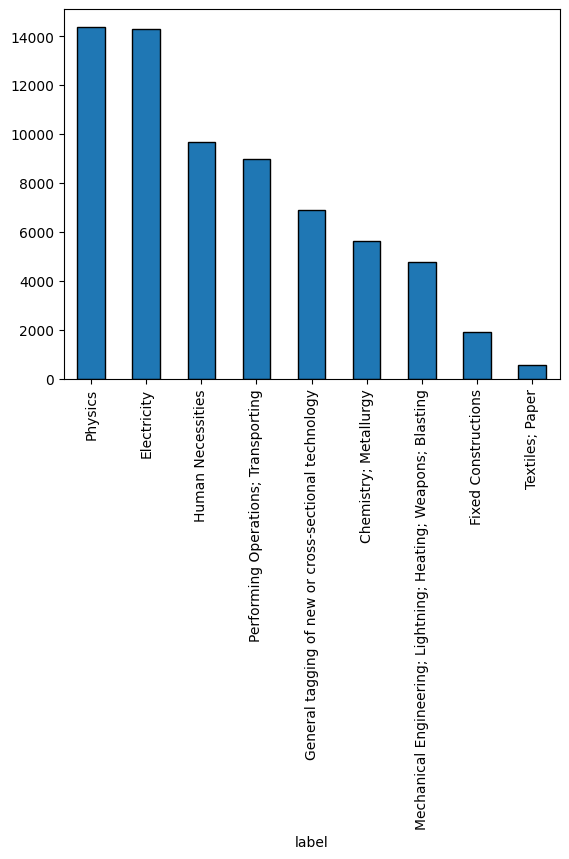


Word count statistics:
count    67068.000000
mean       107.325729
std         46.772428
min         13.000000
25%         73.000000
50%        103.000000
75%        137.000000
max        562.000000
Name: word_count, dtype: float64


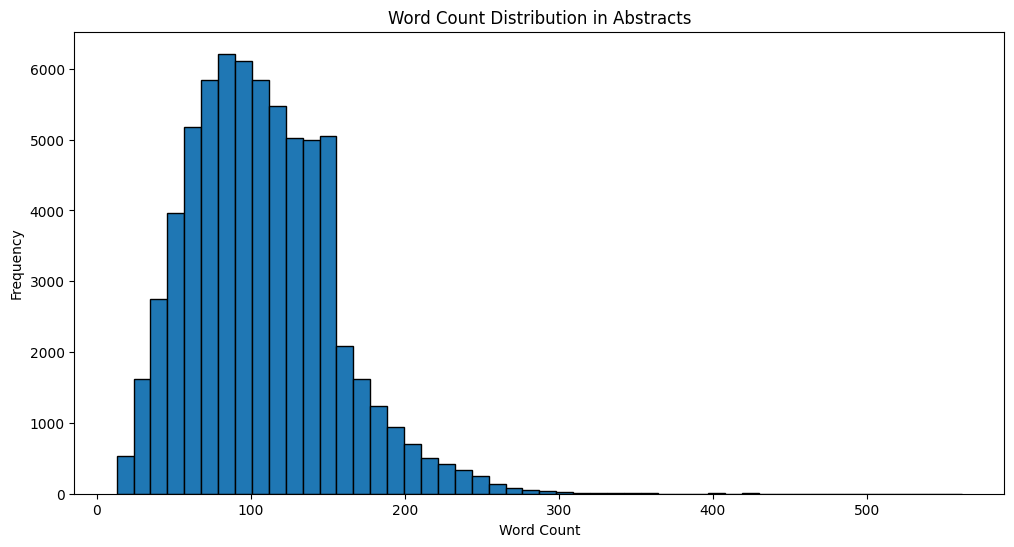

In [ ]:
def explore_dataset(df):
    """
    Perform exploratory data analysis on the dataset.

    Args:
        df (pd.DataFrame): The dataset to explore.
    """
    print(df.info())
    print("\nSample Data:")
    print(df.head())

    # Count patents by category
    category_counts = df['label'].value_counts()
    print("\nNumber of patents in each category:")
    print(category_counts)
    category_counts.plot(kind='bar', edgecolor='black')
    plt.show()

    # Add word count for abstracts
    df['word_count'] = df['abstract'].apply(lambda x: len(str(x).split()))
    print("\nWord count statistics:")
    print(df['word_count'].describe())

    # Plot word count distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df['word_count'], bins=50, edgecolor='black')
    plt.title('Word Count Distribution in Abstracts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

# Analyze the dataset
explore_dataset(total_abstracts_df)


## Financial Categories

In [ ]:
def parse_financial_topics(file_path):
    """
    Parse a text file containing financial topics and their associated keywords.

    Args:
        file_path (str): Path to the text file containing financial topics and keywords.

    Returns:
        dict: A dictionary with topics as keys and lists of keywords as values.
    """
    topics_dict = {}
    current_topic = None
    current_keywords = []

    with open(file_path, 'r', encoding="utf-8-sig") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue

            # Check if it's a new topic
            topic_match = re.match(r'^\d+\.\s(.+)$', line)
            if topic_match:
                # Save previous topic if exists
                if current_topic and current_keywords:
                    topics_dict[current_topic] = current_keywords

                current_topic = topic_match.group(1)
                current_keywords = []
            elif line.startswith('[') and line.endswith(']'):
                # Parse the keywords
                keywords = [keyword.strip() for keyword in line[1:-1].split(',')]
                current_keywords.extend(keywords)
            elif current_topic and not line.startswith('['):
                # Handle multi-line keywords (like in Virtual Reality)
                current_keywords.extend([keyword.strip() for keyword in line.split(',')])

    # Add the last topic
    if current_topic and current_keywords:
        topics_dict[current_topic] = current_keywords

    return topics_dict

# Usage
file_path = 'sample_data/financial_topics.txt'
topics_keywords_dict = parse_financial_topics(file_path)

## Train Validate Test Split


In [ ]:
def add_set_labels(label):
  """
    Split the dataset into Train, Validation, and Test sets.

    Args:
        label (str): Label for the dataset to process.

    Returns:
        pd.DataFrame: DataFrame with the split sets labeled.
  """

  label_df = pd.read_pickle(f'sample_data/public_patents_dataset(label {label}).pkl')

  label_df['Patent ID'] = label_df.index


  train_val, test = train_test_split(label_df, test_size=.20, random_state=1234)
  train, val = train_test_split(label_df, test_size=.25, random_state=1234)
  # Create new column with default value
  label_df['set'] = 'none'
  # Assign correct values to each set
  label_df.loc[train.index, 'set'] = 'Train'
  label_df.loc[val.index, 'set'] = 'Validate'
  label_df.loc[test.index, 'set'] = 'Test'
  return label_df

In [ ]:
df_list = []
for label in ['a','b','c','d','d','e','f','g','h','y']:
  df_list.append(add_set_labels(label))
total_abstracts_df_sets = pd.concat(df_list, ignore_index=True)

total_abstracts_df_sets['Patent ID'] = total_abstracts_df_sets.index

total_abstracts_df_sets.to_csv('total_abstracts_df_sets.csv', index=False)
